OpenGAN: Open-Set Recognition via Open Data Generation
================
**Supplemental Material for ICCV2021 Submission**


In this notebook, we demonstrate cross-domain open-set image classification.
Specifically, we show how we evaluate the model over diverse open-set images.
We also visualize the "landscape" of the open-set discriminator. 

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import libmr
import pandas as pd
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils

from utils.eval_funcs import *
from utils.dataset_tinyimagenet_3sets import *
from utils.dataset_cifar10 import *
from utils.network_arch_tinyimagenet import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)


manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.4.0+cu92
Random Seed:  999


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# set the random seed
torch.manual_seed(0)

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

modelFlag = 'Res18sc'

# This is the directory from which we read a checkpoint.
# We are showing a GAN-fea model, which is trained only on the real, closed-set images.
project_name = 'step002_GANfea_v1_' + modelFlag

# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:1'


total_epoch_num = 100 # total number of epoch in training
batch_size = 128    
insertConv = False    
embDimension = 64
isPretrained = False

newsize = (64, 64)


bestEpoch = 99


# Number of channels in the training images. For color images this is 3
nc = 512
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1




nClassTotal = 200
nClassCloseset = nClassTotal


lr = 0.0001 # base learning rate

num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/step002_GANfea_v1_Res18pt


Define model architecture
---------

Here is the definition of the model architecture. 

In [3]:
encoder_num_layers = 18
embDimension = -1 # negative values meaning there is no intermediate layers; otherwise there is an addition layer for dimensionality reduction
bestEpoch=200  # the model epoch as the SOTA classification model on TinyImageNet training data.

exp_dir = './exp' # experiment directory, used for reading the init model
project_name = 'step001_p2_Res18scratch_softmax'

encoder = ResnetEncoder(encoder_num_layers, isPretrained, embDimension=embDimension, poolSize=4)
clsModel = TinyImageNet_ClsNet(nClass=nClassTotal, layerList=(512, ))

folder_to_run = os.path.join(exp_dir, project_name)
path_to_encoder = os.path.join(folder_to_run, 'epoch-{}_encoder.paramOnly'.format(bestEpoch))
path_to_clsnet = os.path.join(folder_to_run, 'epoch-{}_clsnet.paramOnly'.format(bestEpoch))

encoder.load_state_dict(torch.load(path_to_encoder))
clsModel.load_state_dict(torch.load(path_to_clsnet))

encoder.cuda();
encoder.eval();
encoder.to(device);
clsModel.cuda();
clsModel.eval();
clsModel.to(device);

## Set some random colors for colorful visualizaton


In [4]:
rgb_cycle = [
    [1,0,0],
    [0,1,0],
    [1,0,1],
    [0,1,1], 
    [0.3,1,1],
    [1,0.3,1],
    [0.3,1,0.3],
    [1,0.3,0.3], 
    [0.1,0.5,1],
    [1,0.5,0.1],
    [0.1,0.5,0.5],
    [1,0.8,0.2],
]
rgb_cycle = np.asarray(rgb_cycle).astype(np.float32)
rgb_cycle = np.concatenate( (rgb_cycle, rgb_cycle*0.6, rgb_cycle*0.3 ), axis=0)


## setup for GAN-fea

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     
        

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=512):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
            #nn.Tanh()
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=512, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

## read a GAN-fea model

In [8]:
bestEpoch = 50 # we fetch the model at epoch-50 

netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator(ngpu=ngpu, nc=nc, ndf=ndf).to(device)
path_to_G = os.path.join(save_dir, 'epoch-{}.GNet'.format(bestEpoch))
path_to_D = os.path.join(save_dir, 'epoch-{}.DNet'.format(bestEpoch))
netG.load_state_dict(torch.load(path_to_G))
netD.load_state_dict(torch.load(path_to_D))

<All keys matched successfully>

## Sanity check

In [9]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)
predLabel = netD(fake)

print(noise.shape, fake.shape, predLabel.shape)

torch.Size([128, 100, 1, 1]) torch.Size([128, 512, 1, 1]) torch.Size([128, 1, 1, 1])


dataset setup -- TinyImageNet as the closed set
-----------

In [10]:
imgTransformList = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

targetTransformList = transforms.Compose([
    transforms.ToTensor(),    
])


testset_closeset = TINYIMAGENET(size=newsize, set_name='test', isAugment=False) 
dataloader_test_closeset = DataLoader(testset_closeset, batch_size=batch_size, shuffle=True, num_workers=4)
print(len(testset_closeset))
data_sampler = iter(dataloader_test_closeset)
imageList, labelList = next(data_sampler)

10000


# open-set recognition

GAN for open-set recognition

##  running discriminator on TinyImageNet test-set (closed test-set)

In [12]:
# open & close-set testing

feat_close_tinyimagenet = torch.tensor([]).type(torch.float)
label_close_tinyimagenet = torch.tensor([]).type(torch.float)
conf_close_tinyimagenet = torch.tensor([]).type(torch.float)

i = 0
count = 0
for sample in dataloader_test_closeset:    
    image, label = sample
    image = image.to(device)
    label = label.type(torch.long).view(-1).to(device)    
    count += image.shape[0]
    i+=1 
    feats = encoder(image)
    feats = feats.unsqueeze_(-1).unsqueeze_(-1)
    predConf = netD(feats)    
    predConf = predConf.view(-1,1)
    conf_close_tinyimagenet = torch.cat((conf_close_tinyimagenet, predConf.reshape(-1).detach().cpu()), 0)
    
    feats = feats.squeeze()
    feat_close_tinyimagenet = torch.cat((feat_close_tinyimagenet, feats.detach().cpu()))
    label_close_tinyimagenet = torch.cat((label_close_tinyimagenet, label.type(torch.float).detach().cpu().reshape(-1,1))) 
        
conf_close_tinyimagenet = conf_close_tinyimagenet.detach().cpu().numpy()
print(conf_close_tinyimagenet.shape)

(10000,)


##  running discriminator on CIFAR10 test-set (open test-set)

We draw the ROC curve for classifying closed-set and open-set data.

(10000,) (6000,)
0.9955319


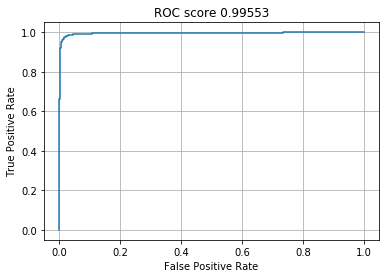

In [13]:
from utils.dataset_cifar10 import *

feat_open_cifar10 = torch.tensor([]).type(torch.float)
label_open_cifar10 = torch.tensor([]).type(torch.float)
conf_open_cifar10 = torch.tensor([]).type(torch.float)

testset_openset = CIFAR_OPENSET_CLS(set_name='test', numKnown=4, numTotal=10, runIdx=5, isOpenset=True, isAugment=False)
dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True, num_workers=4)


i = 0
count = 0
for sample in dataloader_test_openset:
    image, label = sample
    image = F.interpolate(image, scale_factor=2, mode='bilinear')
    image = image.to(device)    
    count += image.shape[0]
    i+=1    
    feats = encoder(image)
    feats = feats.unsqueeze_(-1).unsqueeze_(-1)
    predConf = netD(feats)        
    predConf = predConf.view(-1,1).detach()
    conf_open_cifar10 = torch.cat((conf_open_cifar10, predConf.reshape(-1).detach().cpu()), 0)
    
    feats = feats.squeeze()
    feat_open_cifar10 = torch.cat((feat_open_cifar10, feats.detach().cpu()))
    label_open_cifar10 = torch.cat((label_open_cifar10, label.type(torch.float).detach().cpu().reshape(-1,1))) 
    

conf_open_cifar10 = conf_open_cifar10.detach().cpu().numpy()        
roc_score, roc_to_plot = evaluate_openset(-conf_close_tinyimagenet, -conf_open_cifar10)


print(conf_close_tinyimagenet.shape, conf_open_cifar10.shape)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

##  running discriminator on SVHN test-set (open test-set)

We draw the ROC curve for classifying closed-set and open-set data.

(10000,) (26032,)
0.9947829901659495


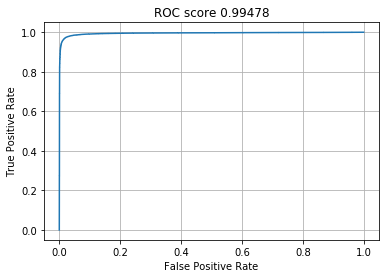

In [14]:
from utils.dataset_svhn import *

feat_open_svhn = torch.tensor([]).type(torch.float)
label_open_svhn = torch.tensor([]).type(torch.float)
conf_open_svhn = torch.tensor([]).type(torch.float)

testset_openset = SVHN_OPENSET_CLS(set_name='test', numKnown=nClassCloseset, numTotal=nClassTotal, runIdx=0, isOpenset=False, isAugment=False)
dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True, num_workers=4)


i = 0
count = 0
for sample in dataloader_test_openset:
    image, label = sample
    image = F.interpolate(image, scale_factor=2, mode='bilinear')
    image = image.to(device)    
    count += image.shape[0]
    i+=1    
    feats = encoder(image)
    feats = feats.unsqueeze_(-1).unsqueeze_(-1)
    predConf = netD(feats)        
    predConf = predConf.view(-1,1).detach()
    conf_open_svhn = torch.cat((conf_open_svhn, predConf.reshape(-1).detach().cpu()), 0)

    feats = feats.squeeze()
    feat_open_svhn = torch.cat((feat_open_svhn, feats.detach().cpu()))
    label_open_svhn = torch.cat((label_open_svhn, label.type(torch.float).detach().cpu().reshape(-1,1))) 


conf_open_svhn = conf_open_svhn.detach().cpu().numpy()        
roc_score, roc_to_plot = evaluate_openset(-conf_close_tinyimagenet, -conf_open_svhn)


print(conf_close_tinyimagenet.shape, conf_open_svhn.shape)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

##  running discriminator on MNIST test-set (open test-set)

We draw the ROC curve for classifying closed-set and open-set data.

(10000,) (10000,)
0.9935011699999999


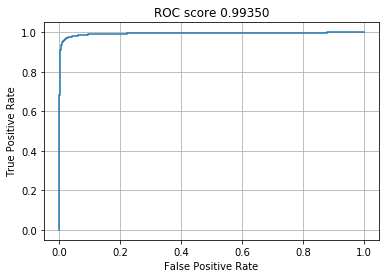

In [15]:
from utils.dataset_mnist import *

testset_openset = MNIST_CLS_openset(set_name='test', numKnown=nClassCloseset, numTotal=nClassTotal, runIdx=0, isOpenset=False)
dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True, num_workers=4)

label_open_mnist = torch.tensor([]).type(torch.float)
feat_open_mnist = torch.tensor([]).type(torch.float)
conf_open_mnist = torch.tensor([]).type(torch.float)

i = 0
count = 0
for sample in dataloader_test_openset:
    image, label = sample
    image = F.interpolate(image, size=(64,64), mode='bilinear')
    image = image.repeat(1,3,1,1)
    image = image.to(device)    
    count += image.shape[0]
    i+=1    
    feats = encoder(image)
    feats = feats.unsqueeze_(-1).unsqueeze_(-1)
    predConf = netD(feats)        
    predConf = predConf.view(-1,1).detach()
    conf_open_mnist = torch.cat((conf_open_mnist, predConf.reshape(-1).detach().cpu()), 0)

    feats = feats.squeeze()
    feat_open_mnist = torch.cat((feat_open_mnist, feats.detach().cpu()))
    label_open_mnist = torch.cat((label_open_mnist, label.type(torch.float).detach().cpu().reshape(-1,1))) 

    
conf_open_mnist = conf_open_mnist.detach().cpu().numpy()        
roc_score, roc_to_plot = evaluate_openset(-conf_close_tinyimagenet, -conf_open_mnist)



print(conf_close_tinyimagenet.shape, conf_open_mnist.shape)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

##  running discriminator on Cityscapes test-set (open test-set)

0.9984631999999999


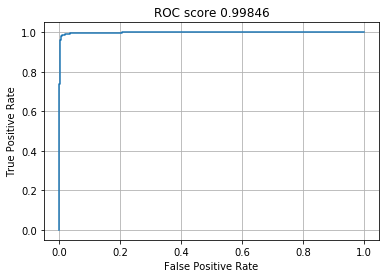

In [16]:
from utils.dataset_cityscapes import *


imgTransformList = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

targetTransformList = transforms.Compose([
    transforms.ToTensor(),    
])

testset_openset = Cityscapes(root='/scratch/dataset/Cityscapes',
                             newsize=newsize, split='val', mode='fine',
                             target_type='semantic', transform=imgTransformList,
                             target_transform=targetTransformList, transforms=None)

dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True, num_workers=4)


conf_open_cityscapes = torch.tensor([]).type(torch.float)
label_open_cityscapes = torch.tensor([]).type(torch.float)
feat_open_cityscapes = torch.tensor([]).type(torch.float)

i = 0
count = 0
for sample in dataloader_test_openset:
    image, label = sample
    image = image.to(device)    
    label = torch.zeros(image.shape[0]).type(torch.long).view(-1).to(device)
    count += image.shape[0]
    i+=1    
    feats = encoder(image)
    feats = feats.unsqueeze_(-1).unsqueeze_(-1)
    predConf = netD(feats)        
    predConf = predConf.view(-1,1).detach()
    conf_open_cityscapes = torch.cat((conf_open_cityscapes, predConf.reshape(-1).detach().cpu()), 0)

    feats = feats.squeeze()
    feat_open_cityscapes = torch.cat((feat_open_cityscapes, feats.detach().cpu()))
    label_open_cityscapes = torch.cat((label_open_cityscapes, 3+label.type(torch.float).detach().cpu().reshape(-1,1))) 

    
conf_open_cityscapes = conf_open_cityscapes.detach().cpu().numpy()        
roc_score, roc_to_plot = evaluate_openset(-conf_close_tinyimagenet, -conf_open_cityscapes)



plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

# PCA on real data

In [17]:
featMat = torch.cat((feat_close_tinyimagenet,
                     feat_open_cifar10,
                     feat_open_svhn,
                     feat_open_mnist,
                     feat_open_cityscapes
                    ))
featMat = featMat.numpy()

subset_label_close_tinyimagenet = label_close_tinyimagenet
subset_label_open_cifar10 = label_open_cifar10
subset_label_open_svhn = label_open_svhn
subset_label_open_mnist = label_open_mnist
subset_label_open_cityscapes = label_open_mnist


labelList = torch.cat((label_close_tinyimagenet*0, 
                       label_open_cifar10-3,
                       6+(label_open_svhn+1),
                       16+(label_open_mnist+1),
                       30+(label_open_cityscapes),
                      ))
labelList = labelList.numpy()


confList = np.concatenate((
    conf_close_tinyimagenet,
    conf_open_cifar10,
    conf_open_svhn,
    conf_open_mnist,
    conf_open_cityscapes,
))

In [18]:
featMat.shape, labelList.shape, confList.shape

((52532, 512), (52532, 1), (52532,))

In [19]:
from sklearn.decomposition import PCA

pcaFunc512 = PCA(n_components=512)
pcaFunc2 = PCA(n_components=2)


X =  featMat.copy()

pcaFunc2.fit(X)
pcaFunc512.fit(X)


pcaX512 = pcaFunc512.transform(X)
print(pcaX512.shape)
YY512 = pcaX512[:,:2]
print(YY512.shape)

pcaX2 = pcaFunc2.transform(X)
print(pcaX2.shape)
YY2 = pcaX2[:,:2]
print(YY2.shape)

(52532, 512)
(52532, 2)
(52532, 2)
(52532, 2)


In [20]:
X_hat = pcaFunc512.inverse_transform(pcaX512) 

a = np.abs(X_hat-X)
print(a.max(), a.min())

print(X.shape, X.max(), X.min())

8.34465e-06 0.0
(52532, 512) 7.434728 0.0


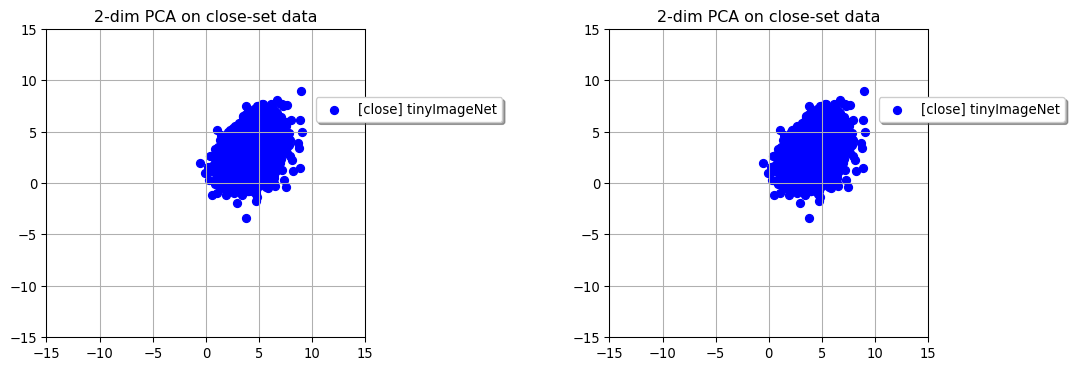

In [21]:
figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(12,4), dpi=95, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    



plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
a = np.where(labelList==0)
curClsData = YY2[a[0],:]
plt.scatter(curClsData[:,0], curClsData[:,1], c=np.asarray([0,0,1]).reshape(1,-1), label='[close] tinyImageNet')
plt.title('2-dim PCA on close-set data')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.grid('on')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.tight_layout()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
a = np.where(labelList==0)
curClsData = YY512[a[0],:]
plt.scatter(curClsData[:,0], curClsData[:,1], c=np.asarray([0,0,1]).reshape(1,-1), label='[close] tinyImageNet')
plt.title('2-dim PCA on close-set data')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.grid('on')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.tight_layout()

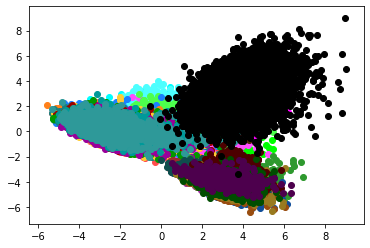

In [22]:
YY = pcaX2
fig, ax = plt.subplots()
for curCls in range(1,120):
    a = np.where(labelList==curCls)
    if len(a[0])==0: continue
    curClsData = YY[a[0],:]
    ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[curCls].reshape(1,-1))

a = np.where(labelList==0)
curClsData = YY[a[0],:]
ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[0].reshape(1,-1)*0)

#plt.axis('off')

## PCA on synthesized data 
Note that we run deep-dream techniques to "tweak" images towards a desired low/high probability of being classified as open/closed data. This augments the "fake open-set" data and helps fill in the space for better visualization.

In [23]:
folder_to_save = 'dreamFolder'
filename_to_save = path.join(folder_to_save, 'dreamDict_tinyImageNet.pkl')

with open(filename_to_save, "rb") as fn:
    dreamDict_tinyImageNet = pickle.load(fn)
    
print(dreamDict_tinyImageNet.keys())
print(dreamDict_tinyImageNet['dreamDict_label_tinyImageNet'].keys())
print(dreamDict_tinyImageNet['dreamDict_image_tinyImageNet'][0.5].shape)

dict_keys(['dreamDict_image_tinyImageNet', 'dreamDict_label_tinyImageNet'])
dict_keys([0.4, 0.5, 0.6, 0.7, 0.8])
torch.Size([1024, 3, 64, 64])


In [24]:
targetConfList = [0.4, 0.5, 0.6, 0.7, 0.8]

dream_feat_close_tinyimagenet = torch.tensor([]).type(torch.float)
dream_label_close_tinyimagenet = torch.tensor([]).type(torch.float)
dream_conf_close_tinyimagenet = torch.tensor([]).type(torch.float)


for targetConf in targetConfList:
    print('target probability: {:.2f}'.format(targetConf))
    
    label = dreamDict_tinyImageNet['dreamDict_label_tinyImageNet'][targetConf]
    stackedImg = dreamDict_tinyImageNet['dreamDict_image_tinyImageNet'][targetConf]
    with torch.no_grad():
        feats = encoder(stackedImg.to(device))
        feats = feats.unsqueeze_(-1).unsqueeze_(-1)
        predConf = netD(feats).detach()
        predConf = predConf.view(-1,1)
    
    dream_conf_close_tinyimagenet = torch.cat((dream_conf_close_tinyimagenet, predConf.reshape(-1).detach().cpu()))
    dream_feat_close_tinyimagenet = torch.cat((dream_feat_close_tinyimagenet, feats.detach().cpu()))
    dream_label_close_tinyimagenet = torch.cat((dream_label_close_tinyimagenet, label.type(torch.float).detach().cpu().reshape(-1,1)))        

target probability: 0.40
target probability: 0.50
target probability: 0.60
target probability: 0.70
target probability: 0.80


In [25]:
targetConfList = [0.2, 0.3, 0.4, 0.5, 0.6]

dream_feat_open_cifar10 = torch.tensor([]).type(torch.float)
dream_label_open_cifar10 = torch.tensor([]).type(torch.float)
dream_conf_open_cifar10 = torch.tensor([]).type(torch.float)


folder_to_save = 'dreamFolder'
filename_to_save = path.join(folder_to_save, 'dreamDict_cifar.pkl')

with open(filename_to_save, "rb") as fn:
    dreamDict_cifar = pickle.load(fn)
    
    
for targetConf in targetConfList:
    print('target probability: {:.2f}'.format(targetConf))
    
    label = dreamDict_cifar['dreamDict_label_cifar'][targetConf]
    stackedImg = dreamDict_cifar['dreamDict_image_cifar'][targetConf]
    with torch.no_grad():
        feats = encoder(stackedImg.to(device))
        feats = feats.unsqueeze_(-1).unsqueeze_(-1)
        predConf = netD(feats).detach()
        predConf = predConf.view(-1,1)
    
    dream_conf_open_cifar10 = torch.cat((dream_conf_open_cifar10, predConf.reshape(-1).detach().cpu()))
    dream_feat_open_cifar10 = torch.cat((dream_feat_open_cifar10, feats.detach().cpu()))
    dream_label_open_cifar10 = torch.cat((dream_label_open_cifar10, label.type(torch.float).detach().cpu().reshape(-1,1)))       

target probability: 0.20
target probability: 0.30
target probability: 0.40
target probability: 0.50
target probability: 0.60


In [26]:
targetConfList = [0.2, 0.3, 0.4, 0.5, 0.6]

dream_feat_open_svhn = torch.tensor([]).type(torch.float)
dream_label_open_svhn = torch.tensor([]).type(torch.float)
dream_conf_open_svhn = torch.tensor([]).type(torch.float)


folder_to_save = 'dreamFolder'
filename_to_save = path.join(folder_to_save, 'dreamDict_svhn.pkl')

with open(filename_to_save, "rb") as fn:
    dreamDict_svhn = pickle.load(fn)
    
    
    
    
for targetConf in targetConfList:
    print('target probability: {:.2f}'.format(targetConf))
    
    label = dreamDict_svhn['dreamDict_label_svhn'][targetConf]
    stackedImg = dreamDict_svhn['dreamDict_image_svhn'][targetConf]
    with torch.no_grad():
        feats = encoder(stackedImg.to(device))
        feats = feats.unsqueeze_(-1).unsqueeze_(-1)
        predConf = netD(feats).detach()
        predConf = predConf.view(-1,1)
    
    dream_conf_open_svhn = torch.cat((dream_conf_open_svhn, predConf.reshape(-1).detach().cpu()))
    dream_feat_open_svhn = torch.cat((dream_feat_open_svhn, feats.detach().cpu()))
    dream_label_open_svhn = torch.cat((dream_label_open_svhn, label.type(torch.float).detach().cpu().reshape(-1,1)))    

target probability: 0.20
target probability: 0.30
target probability: 0.40
target probability: 0.50
target probability: 0.60


In [27]:
targetConfList = [0.2, 0.3, 0.4, 0.5, 0.6]

dream_feat_open_mnist = torch.tensor([]).type(torch.float)
dream_label_open_mnist = torch.tensor([]).type(torch.float)
dream_conf_open_mnist = torch.tensor([]).type(torch.float)



folder_to_save = 'dreamFolder'
filename_to_save = path.join(folder_to_save, 'dreamDict_mnist.pkl')

with open(filename_to_save, "rb") as fn:
    dreamDict_mnist = pickle.load(fn)
        
    
for targetConf in targetConfList:
    print('target probability: {:.2f}'.format(targetConf))
    
    label = dreamDict_mnist['dreamDict_label_mnist'][targetConf]
    stackedImg = dreamDict_mnist['dreamDict_image_mnist'][targetConf]
    with torch.no_grad():
        feats = encoder(stackedImg.to(device))
        feats = feats.unsqueeze_(-1).unsqueeze_(-1)
        predConf = netD(feats).detach()
        predConf = predConf.view(-1,1)
    
    dream_conf_open_mnist = torch.cat((dream_conf_open_mnist, predConf.reshape(-1).detach().cpu()))
    dream_feat_open_mnist = torch.cat((dream_feat_open_mnist, feats.detach().cpu()))
    dream_label_open_mnist = torch.cat((dream_label_open_mnist, label.type(torch.float).detach().cpu().reshape(-1,1)))    

target probability: 0.20
target probability: 0.30
target probability: 0.40
target probability: 0.50
target probability: 0.60


In [28]:
dreamFeatMat = torch.cat((
    feat_close_tinyimagenet.squeeze(),
    dream_feat_close_tinyimagenet.squeeze(),
    dream_feat_open_cifar10.squeeze(),
    dream_feat_open_svhn.squeeze(),
    dream_feat_open_mnist.squeeze()
))
dreamFeatMat = dreamFeatMat.numpy()

dreamLabelList = torch.cat((label_close_tinyimagenet*0,
                            dream_label_close_tinyimagenet*0+1,
                            dream_label_open_cifar10,
                            6+(dream_label_open_svhn+1),
                            16+(dream_label_open_mnist+1)
                           ))
dreamLabelList = dreamLabelList.numpy()


dreamConfList = np.concatenate((
    conf_close_tinyimagenet,
    dream_conf_close_tinyimagenet,
    dream_conf_open_cifar10,
    dream_conf_open_svhn,
    dream_conf_open_mnist,
))

In [29]:
pcaFunc512dream = PCA(n_components=512)
pcaFunc2dream = PCA(n_components=2)


Xdream =  dreamFeatMat.copy()
# a = np.linalg.norm(X, 2, axis=1).reshape(-1,1)
# X = X/a

#MEAN = X.mean(0)
#X -= MEAN


pcaFunc2dream.fit(Xdream)
pcaFunc512dream.fit(Xdream)


pcaX512dream = pcaFunc512dream.transform(Xdream)
print(pcaX512dream.shape)
YY512dream = pcaX512dream[:,:2]
print(YY512dream.shape)

pcaX2dream = pcaFunc2dream.transform(Xdream)
print(pcaX2dream.shape)
YY2dream = pcaX2dream[:,:2]
print(YY2dream.shape)

(30480, 512)
(30480, 2)
(30480, 2)
(30480, 2)


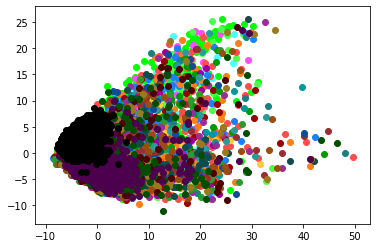

In [31]:
YYdream = pcaX2dream
fig, ax = plt.subplots()
for curCls in range(1,120):
    a = np.where(dreamLabelList==curCls)
    if len(a[0])==0: continue
    curClsData = YYdream[a[0],:]
    ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[curCls].reshape(1,-1))

a = np.where(dreamLabelList==0)
curClsData = YYdream[a[0],:]
ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[0].reshape(1,-1)*0)

#plt.axis('off')

# PCA on combined data

In [32]:
featMatAll = torch.cat((
    feat_close_tinyimagenet.squeeze(),
    feat_open_cifar10,
    feat_open_svhn,
    feat_open_mnist,
    feat_open_cityscapes,
    dream_feat_close_tinyimagenet.squeeze(),
    dream_feat_open_cifar10.squeeze(),
    dream_feat_open_svhn.squeeze(),
    dream_feat_open_mnist.squeeze()
))
featMatAll = featMatAll.numpy()

# Just assign some labels on the mixed data for inidicate the class labels.
labelListAll = torch.cat((label_close_tinyimagenet*0, 
                          label_open_cifar10-3,
                          6+(label_open_svhn+1),
                          16+(label_open_mnist+1),
                          30+(label_open_cityscapes),
                          dream_label_close_tinyimagenet*0+1,
                          dream_label_open_cifar10,
                          6+(dream_label_open_svhn+1),
                          16+(dream_label_open_mnist+1)
                         ))
labelListAll = labelListAll.numpy()


confListAll = np.concatenate((
    conf_close_tinyimagenet,
    conf_open_cifar10,
    conf_open_svhn,
    conf_open_mnist,
    conf_open_cityscapes,
    dream_conf_close_tinyimagenet,
    dream_conf_open_cifar10,
    dream_conf_open_svhn,
    dream_conf_open_mnist,
))



flagListCloseOpen = np.zeros_like(labelListAll)
flagListCloseOpen[:len(label_close_tinyimagenet)] = 1

print(featMatAll.shape, labelListAll.shape, confListAll.shape, flagListCloseOpen.shape)

(73012, 512) (73012, 1) (73012,) (73012, 1)


In [33]:
pcaFunc512all = PCA(n_components=512)
pcaFunc2all = PCA(n_components=2)


Xall =  featMatAll.copy()
# a = np.linalg.norm(Xall, 2, axis=1).reshape(-1,1)
# Xall = Xall/a


MEAN = Xall.mean(0)
Xall -= MEAN


pcaFunc2all.fit(Xall)
pcaFunc512all.fit(Xall)


pcaX512all = pcaFunc512all.transform(Xall)
print(pcaX512all.shape)
pcaX512all = pcaX512all[:,:2]
print(pcaX512all.shape)

pcaX2all = pcaFunc2all.transform(Xall)
print(pcaX2all.shape)
pcaX2all = pcaX2all[:,:2]
print(pcaX2all.shape)

(73012, 512)
(73012, 2)
(73012, 2)
(73012, 2)


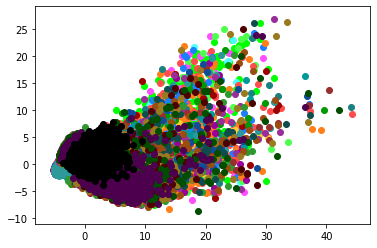

In [34]:
YYall = pcaX2all
fig, ax = plt.subplots()
for curCls in range(1,120):
    a = np.where(labelListAll==curCls)
    if len(a[0])==0: continue
    curClsData = YYall[a[0],:]
    ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[curCls].reshape(1,-1))

a = np.where(labelListAll==0)
curClsData = YYall[a[0],:]
ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[0].reshape(1,-1)*0)



#plt.axis('off')

## zoom in and cut off

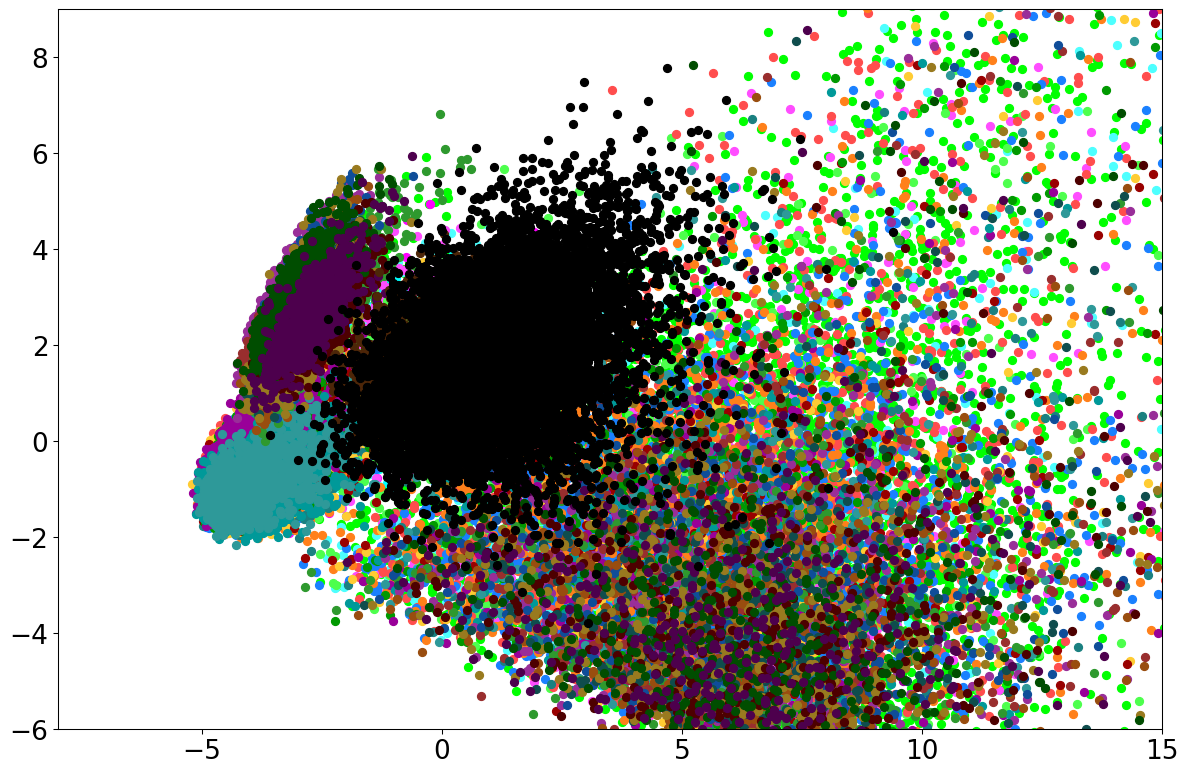

In [153]:
figWinNumHeight, figWinNumWidth = 1, 1
plt.figure(figsize=(15,15), dpi=95, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1



YYall = pcaX2all
for curCls in range(1,120):
    a = np.where(labelListAll==curCls)
    if len(a[0])==0: continue
    curClsData = YYall[a[0],:]
    plt.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[curCls].reshape(1,-1))
    #plt.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[3].reshape(1,-1))

a = np.where(labelListAll==0)
curClsData = YYall[a[0],:]
plt.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[0].reshape(1,-1)*0)

plt.axis('image')
plt.ylim(-6, 9)
plt.xlim(-8, 15)
#plt.axis('off')
plt.xticks(fontsize=20) # , rotation=90
plt.yticks(fontsize=20)


plt.savefig(path.join('landspace_scatter_color.png'),bbox_inches='tight',transparent=True)
plt.savefig(path.join('landspace_scatter_color.eps'))

## open-vs-closed visualization

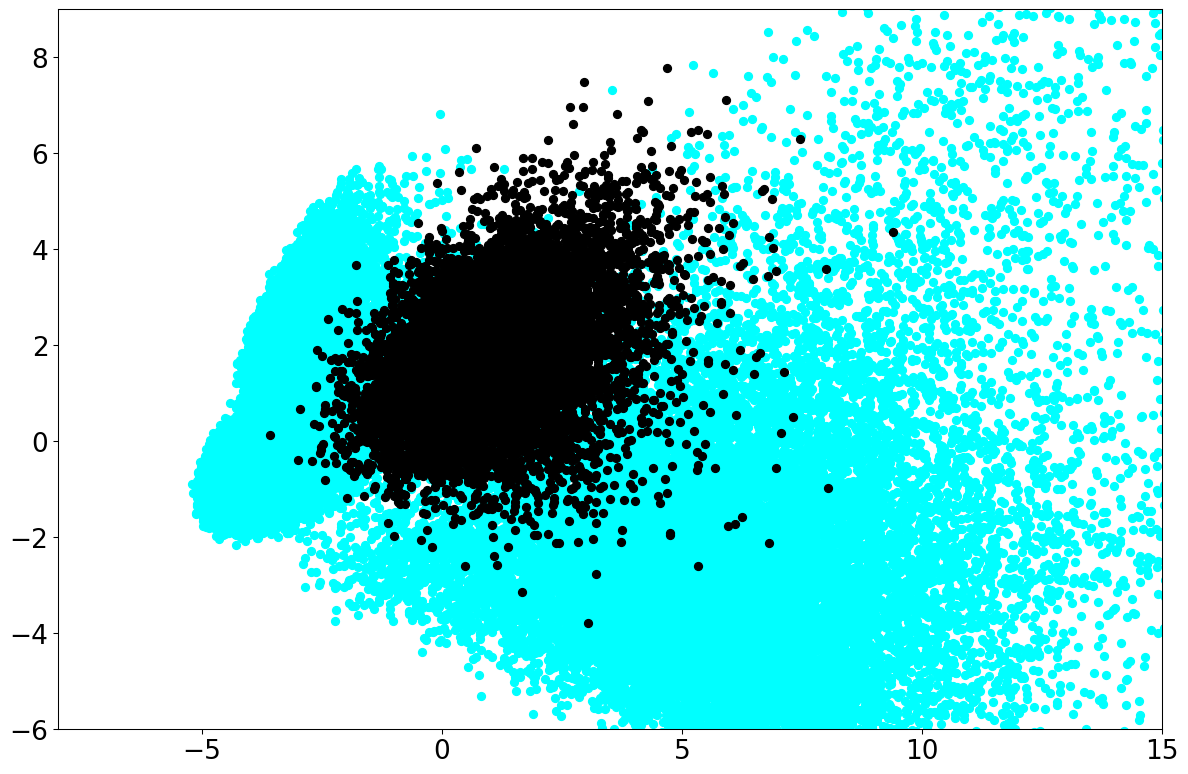

In [154]:
figWinNumHeight, figWinNumWidth = 1, 1
plt.figure(figsize=(15,15), dpi=95, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1



YYall = pcaX2all
for curCls in range(1,120):
    a = np.where(labelListAll==curCls)
    if len(a[0])==0: continue
    curClsData = YYall[a[0],:]
    #plt.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[curCls].reshape(1,-1))
    plt.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[3].reshape(1,-1))

a = np.where(labelListAll==0)
curClsData = YYall[a[0],:]
plt.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[0].reshape(1,-1)*0)

plt.axis('image')
plt.ylim(-6, 9)
plt.xlim(-8, 15)
#plt.axis('off')
plt.xticks(fontsize=20) # , rotation=90
plt.yticks(fontsize=20)


plt.savefig(path.join('landspace_scatter_binary.png'),bbox_inches='tight',transparent=True)
plt.savefig(path.join('landspace_scatter_binary.eps'))

## confidence scores on open-vs-closed classification

In [155]:
scalingFactor = 8
xmax = 15
ymax = 9
xmin = -8
ymin = -6
h, w = ymax-ymin, xmax-xmin

pane = np.zeros((h*scalingFactor, w*scalingFactor)).astype(np.float16)
count = np.ones((h*scalingFactor, w*scalingFactor)).astype(np.float16)/10000

amplifier = 0
for i in range(YYall.shape[0]):
    x, y = YYall[i, :]
    x = (x-xmin)*scalingFactor
    y = (y-ymin)*scalingFactor
    x = np.round(x).astype(np.uint32)
    y = np.round(y).astype(np.uint32)
    if x<w*scalingFactor and y<h*scalingFactor:
        pane[y, x] += confListAll[i]
        count[y, x] += 1

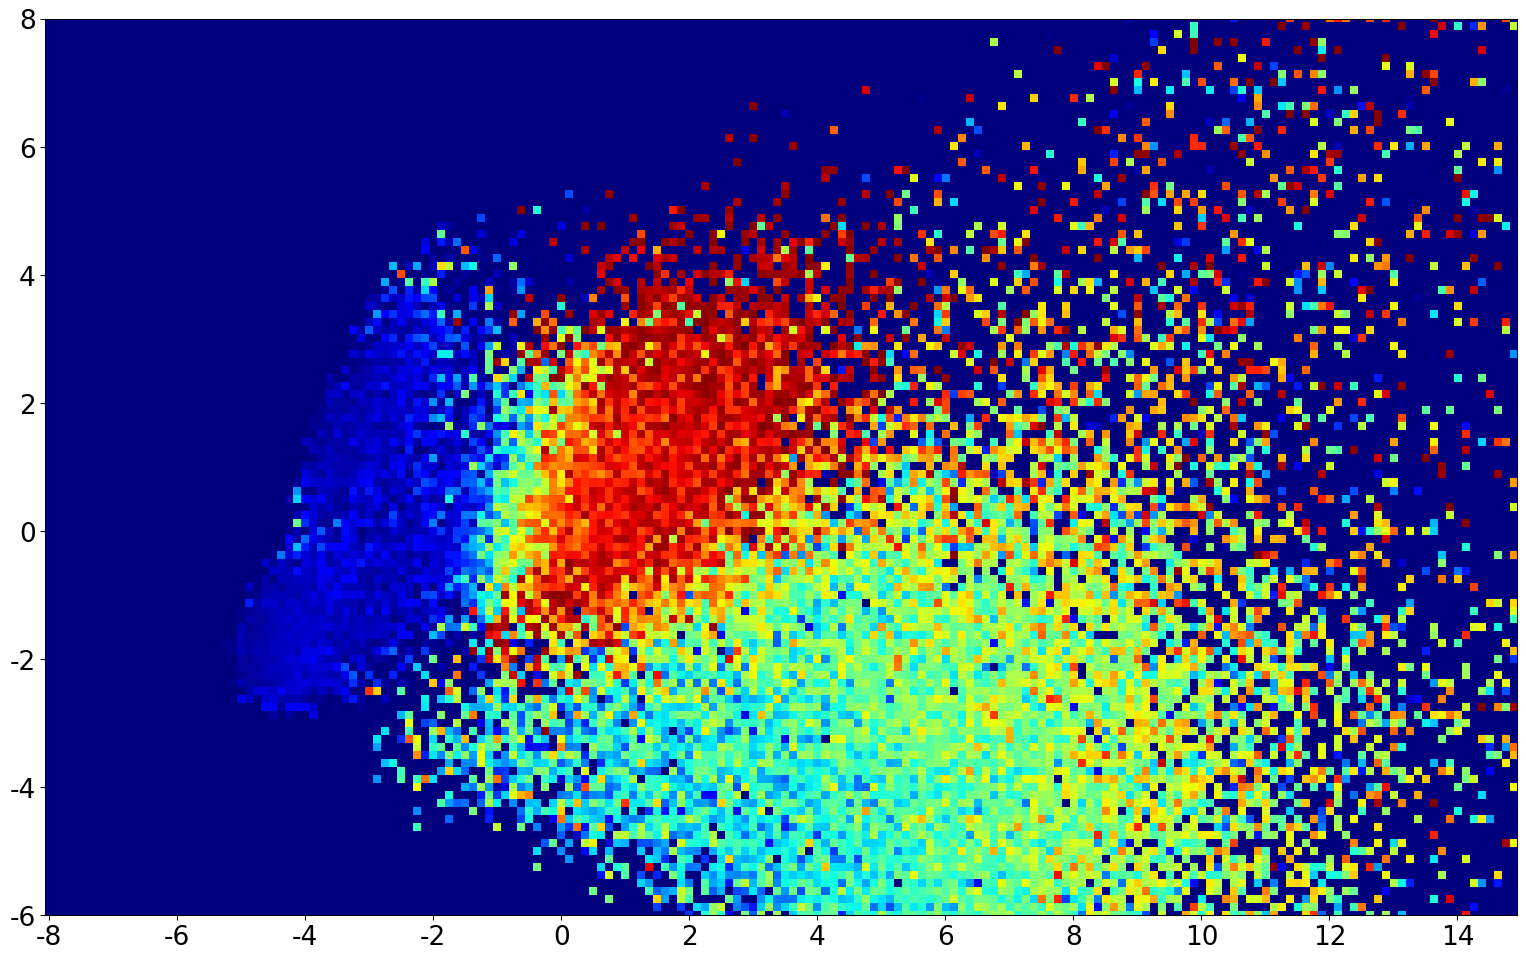

In [158]:
landspaceMap = pane / count

landspaceMap_flipud = np.flipud(landspaceMap)


figWinNumHeight, figWinNumWidth = 1, 1
plt.figure(figsize=(20,20), dpi=95, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1

plt.imshow(landspaceMap_flipud, cmap='jet')

y1 = np.asarray(list(range(0,121,16))).astype(np.float16)
y2 = y1/scalingFactor + ymin
y2 = y2.astype(np.int16)
y2 = y2[::-1]

x1 = np.asarray(list(range(0,185,16))).astype(np.float16)
x2 = x1/scalingFactor + xmin
x2 = x2.astype(np.int16)

plt.xticks(x1, x2) # , rotation=45
plt.yticks(y1, y2) # , rotation=45

plt.xticks(fontsize=20) # , rotation=90
plt.yticks(fontsize=20)

plt.savefig(path.join('landspace_scatter_pane.png'),bbox_inches='tight',transparent=True)
plt.savefig(path.join('landspace_scatter_pane.eps'))

## Blurring the dots and visualize the landscape

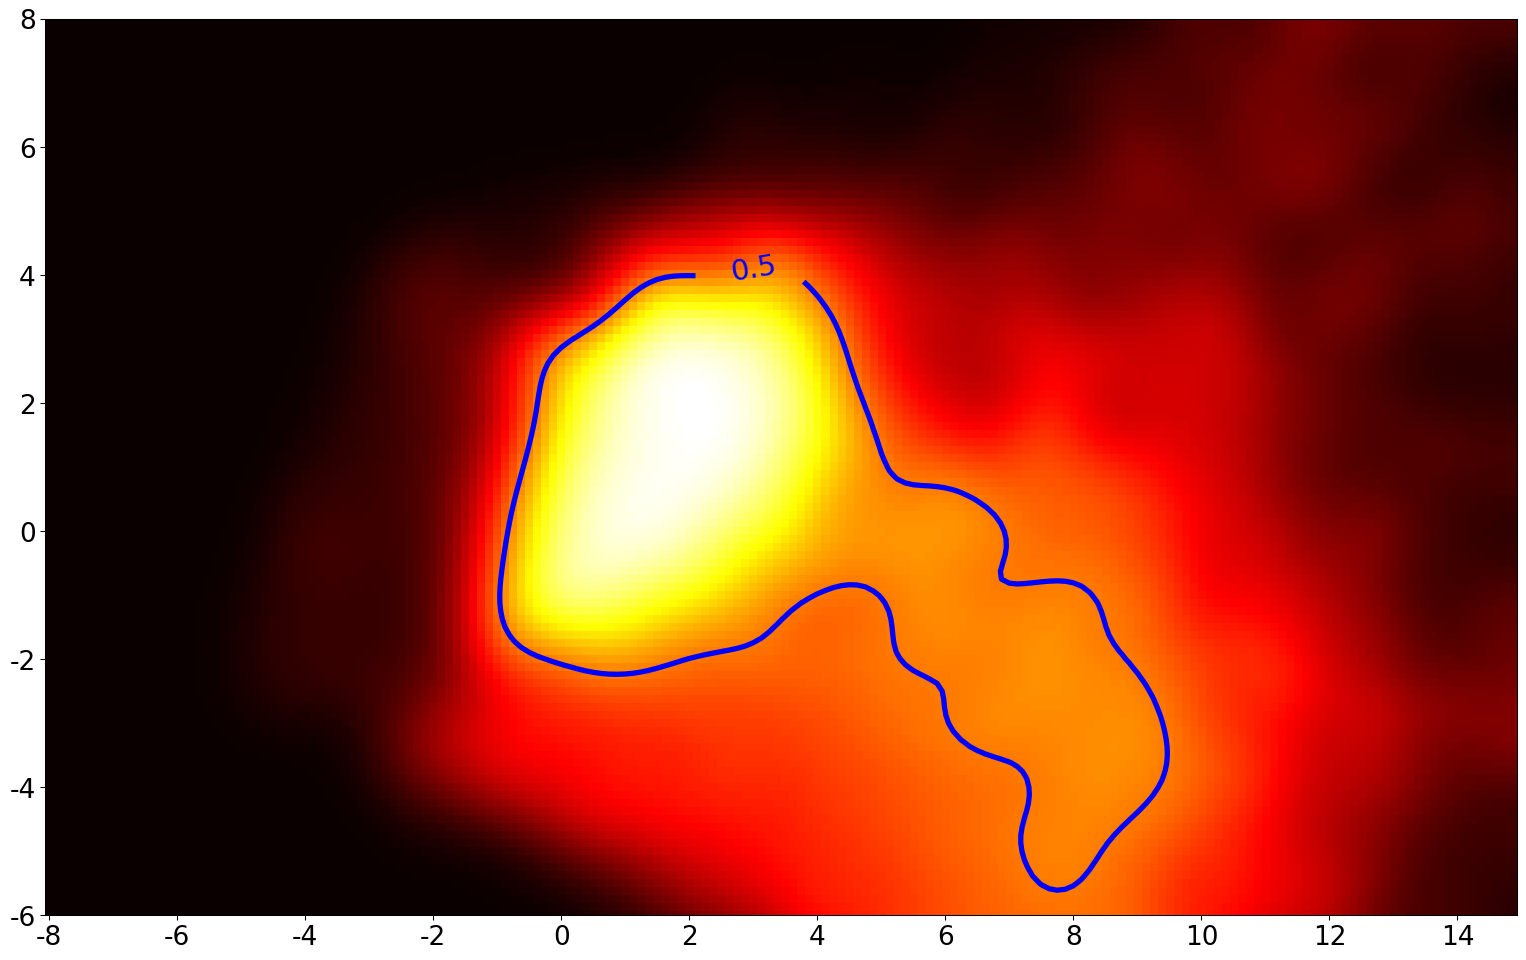

In [159]:
from scipy import misc
from scipy.ndimage import gaussian_filter


landspaceMap_smooth = gaussian_filter(landspaceMap, sigma=4)
landspaceMap_smooth_flipud = np.flipud(landspaceMap_smooth)



figWinNumHeight, figWinNumWidth = 1, 1
plt.figure(figsize=(20,20), dpi=95, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1

plt.imshow(landspaceMap_smooth_flipud, cmap='hot')
plt.axis('image')


y1 = np.asarray(list(range(0,121,16))).astype(np.float16)
y2 = y1/scalingFactor + ymin
y2 = y2.astype(np.int16)
y2 = y2[::-1]

x1 = np.asarray(list(range(0,185,16))).astype(np.float16)
x2 = x1/scalingFactor + xmin
x2 = x2.astype(np.int16)

plt.xticks(x1, x2) # , rotation=45
plt.yticks(y1, y2) # , rotation=45

plt.xticks(fontsize=20) # , rotation=90
plt.yticks(fontsize=20)


ax = plt.gca()
manual_locations = [(85, 25)]
CS = ax.contour(landspaceMap_smooth_flipud, levels=[0.5], colors='b', linestyles='-', linewidths=4)
ax.clabel(CS, fontsize=22, fmt='%.1f', inline=1, inline_spacing=33, manual=manual_locations)


plt.savefig(path.join('landspace_gauss.png'),bbox_inches='tight',transparent=True)
plt.savefig(path.join('landspace_gauss.eps'))